# Probabilistic Autoencoder
TensorFlow 2 implementation of PAE from https://github.com/VMBoehm/PAE (Boehm, Seljak 2020)

The PAE has two main components: 
1. An autoencoder, which learns a compressed representation of the input data
2. A normalizing flow, which learns the distribution of the compressed data

TODO
- move into own files/ python module
- create OOD class that takes in autoencoder & normalizing flow to simplify training/usage

## Autoencoder
From https://www.tensorflow.org/tutorials/generative/autoencoder

This is just a simple autoencoder with a single dense layer

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [5]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


For our use cases, the "decoder" piece of the autoencoder will likely only be used during training

In [6]:
latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In the paper they suggest training for 500+ epochs (I only use 10 for this example)

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0398 - val_loss: 0.0134
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0124 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

Let's look at how the autoencoder reconstructs the test data.

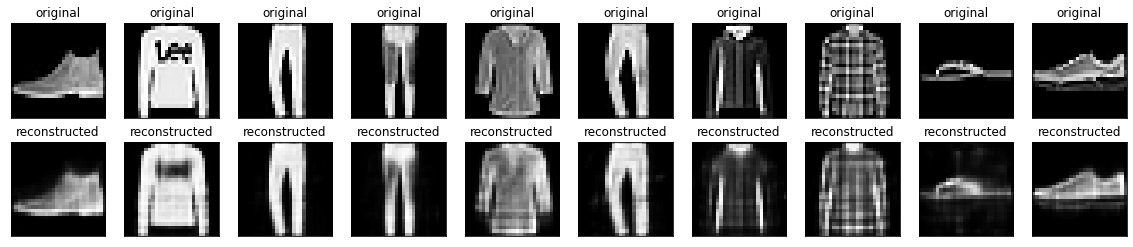

In [9]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Normalizing Flow
Using Tensorflow's implementation of the Masked Autogregressive Flow for Density Estimation (Papamakarios et al. 2017)

Initial code example: https://www.tensorflow.org/probability/api_docs/python/tfp/layers/AutoregressiveTransform

In [10]:
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
tfk = tf.keras

Now we want to train the normalizing flow on the encoded training images:

In [11]:
encoded_imgs = autoencoder.encoder(x_train).numpy()

In [12]:
n = len(encoded_imgs)

class NormalizingFlow(Model):
    def __init__(self):
        super(NormalizingFlow, self).__init__()
        self.model = tfk.Sequential([
            tfk.layers.InputLayer(input_shape=(0,), dtype=tf.float32),
            tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
                loc=tf.zeros(tf.concat([tf.shape(t)[:-1], [latent_dim]], axis=0)))),
            tfpl.AutoregressiveTransform(tfb.AutoregressiveNetwork(
                params=2, hidden_units=[10, 10], activation='relu')),
        ])
    
    def call(self, x):
        return self.model(x)

flow = NormalizingFlow()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.


Compile the normalizing flow with negative log likelihood as the loss function.

In [13]:
flow.compile(optimizer='adam', loss=lambda y, rv_y: -rv_y.log_prob(y))

In [14]:
flow.fit(x=np.zeros((n, 0)),
          y=encoded_imgs,
          epochs=20,
          shuffle=True,
          verbose=True)

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 161.1722
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 103.8032
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 100.6910
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 96.2947
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 95.0795
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 95.6856
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 93.5718
Epoch 8/20
1875/1875 [==============================] - 6s 3ms/step - loss: 93.4907
Epoch 9/20
1875/1875 [==============================] - 6s 3ms/step - loss: 93.4779
Epoch 10/20
1875/1875 [==============================] - 6s 3ms/step - loss: 92.9728
Epoch 11/20
1875/1875 [==============================] - 6s 3ms/step - loss: 93.4256
Epoch 12/20
1875/1875 [==============================] - 5s 3ms/step - 

Aside: we could also do something like this which would be more in-line with how they did it in the original PAE paper. They start with a normal and then use a chain of bijectors to learn the latent space distribution. But, since MADE is based on RealNVP (what they use in paper), might be unecessary.

Note that the below wouldn't work because of how TF2 keeps tracks of variable in lambda layers; you woul need to create a custom layers as suggested here: https://stackoverflow.com/questions/65073434/why-keras-lambda-layer-cause-problem-mask-rcnn

In [15]:
# k = 8

# # start with base distribution (just a normal)
# nvp = tfd.TransformedDistribution(
#     distribution=tfd.MultivariateNormalDiag(loc=np.zeros(k)),
#     bijector=tfb.RealNVP(
#         num_masked=2,
#         shift_and_log_scale_fn=tfb.real_nvp_default_template(
#             hidden_layers=[512, 512]))
# )

# model = tfk.Sequential([
#     tfpl.DistributionLambda(lambda t: nvp) 
# ])

# negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# model.compile(optimizer='adam', loss=negloglik)

## Sampling

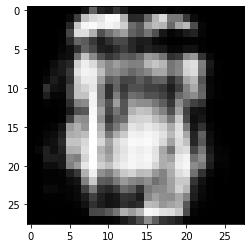

In [16]:
distribution = flow.model(np.zeros(0,))
test_img = distribution.sample(1)
plt.imshow(autoencoder.decoder(test_img)[0])

## Out of Distribution tests

In the PAE paper, they use MNIST as OOD.

In [17]:
from tensorflow.keras.datasets import mnist

(x_train_m, _), (x_test_m, _) = mnist.load_data()
x_train_m = x_train_m.astype('float32') / 255.
x_test_m = x_test_m.astype('float32') / 255.

I chose to use both test sets - I need to check if they do it on the entire datasets in the paper.

In [18]:
mnist_encoded = autoencoder.encoder(x_test_m)
mnist_log_prob = distribution.log_prob(mnist_encoded).numpy()

fmnist_test_encoded = autoencoder.encoder(x_test)
fmnist_log_prob = distribution.log_prob(fmnist_test_encoded).numpy()

First, let's look at the distribution of in/out of distribution samples:

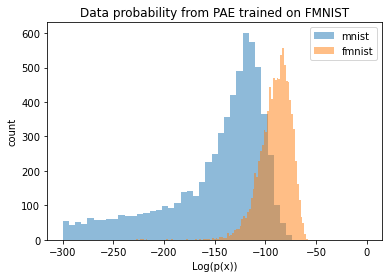

In [19]:
fig, ax = plt.subplots()
h1 = ax.hist(mnist_log_prob, bins='auto', range=(-300, 0), alpha=0.5, label='mnist')
h2 = ax.hist(fmnist_log_prob, bins='auto', range=(-300, 0), alpha=0.5, label='fmnist')
ax.set_title('Data probability from PAE trained on FMNIST')
ax.set_xlabel('Log(p(x))')
ax.set_ylabel('count')
ax.legend()


We can also create the AUC ROC curve:

In [20]:
from sklearn.metrics import roc_curve, auc

labels = np.concatenate((np.ones(len(fmnist_log_prob)), np.zeros(len(mnist_log_prob))))
scores = np.concatenate((fmnist_log_prob, mnist_log_prob))

fpr, tpr, thresholds = roc_curve(y_true=labels, y_score=scores)
auc_score = auc(fpr, tpr)

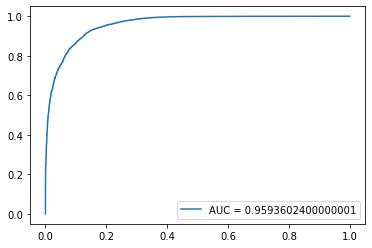

In [21]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label='AUC = {}'.format(auc_score))
ax.legend()